In [1]:
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import laspy
from scipy import ndimage
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

import numpy as np
import laspy
from scipy import ndimage
import os

In [2]:
def print_las_info(las_path):
    """
    Выводит основную информацию о LAS/LAZ файле:
    количество точек, границы (X, Y, Z), размер области и примерную плотность.
    x, y - 
    z - высота
    """
    with laspy.open(las_path) as f:
        header = f.header
        num_points = header.point_count
        min_x, max_x = header.mins[0], header.maxs[0]
        min_y, max_y = header.mins[1], header.maxs[1]
        min_z, max_z = header.mins[2], header.maxs[2]

        width = max_x - min_x
        lenght = max_y - min_y
        area = width * lenght if width > 0 and lenght > 0 else np.nan
        density = num_points / area if area and not np.isnan(area) else np.nan

        print(f"\nФайл: {os.path.basename(las_path)}")
        print(f"Формат версии: {header.version}")
        print(f"Количество точек: {num_points:,}")
        print(f"Диапазон координат (X, Y, Z):")
        print(f"  X: {min_x:.2f} - {max_x:.2f}  (ширина {width:.2f} м)")
        print(f"  Y: {min_y:.2f} - {max_y:.2f}  (размах {lenght:.2f} м)")
        print(f"  Z: {min_z:.2f} - {max_z:.2f}  (высота {max_z - min_z:.2f} м)")
        print(f"Площадь покрытия: {area/1e6:.2f} км²")

        print(f"Средняя плотность: {density:.2f} точек/м²\n")

        # Первые несколько точек
        print("Пример точек:")
        for points in f.chunk_iterator(3):
            for i in range(3):
                print(f"x: {points.x[i]:.2f} y: {points.y[i]:.2f} z: {points.z[i]:.2f}")
            break

In [3]:
def print_array_data(data):
    data = np.array(data)
    print(data.shape)
    print(f"{data.min():.2f} - {data.max():.2f}")
    print(data.mean())
    counts, bins = np.histogram(data)
    plt.stairs(counts, bins)

In [4]:
# folder_path = "/home/chazelam/Code/LiDAR/PMF_out"
# file_name = os.path.join(folder_path, "non_ground.las")
file_name = "non_ground.las"

print_las_info(file_name)


Файл: non_ground.las
Формат версии: 1.2
Количество точек: 18,880,083
Диапазон координат (X, Y, Z):
  X: 3.85 - 10.85  (ширина 7.00 м)
  Y: -3.03 - 3.97  (размах 7.00 м)
  Z: -1.56 - 18.82  (высота 20.39 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 385417.93 точек/м²

Пример точек:
x: 6.08 y: -2.18 z: -1.40
x: 6.09 y: -2.18 z: -1.41
x: 6.09 y: -2.18 z: -1.41


In [5]:
las = laspy.read(file_name)
points = np.vstack((las.x, las.y, las.z)).T
print(f"Loaded {len(points):,} points")

Loaded 18,880,083 points


In [34]:
tree = cKDTree(points)

KeyboardInterrupt: 

[1 1 1 ... 1 1 1]
(18880083,)
1.00 - 7.00
1.088757448788758


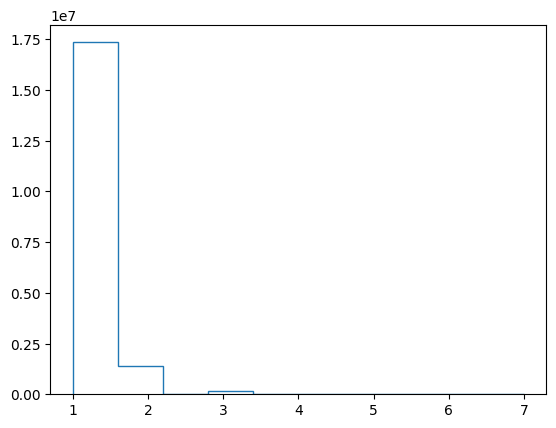

In [37]:
counts_small = tree.query_ball_point(points, r=0.001, workers=-1, return_length=True)

print(counts_small)
np.save("vicinity_of_0.1.npy", counts_small)
print_array_data(counts_small)

(18880083,)
1.00 - 1749.00
80.28385674999416


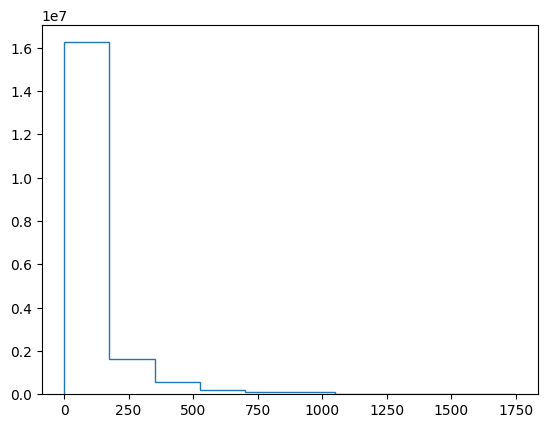

In [7]:
counts_small = tree.query_ball_point(points, r=0.1, workers=-1, return_length=True)

print(counts_small)

[4161 3658 3740 ...   57   28   57]


(18880083,)
1.00 - 102927.00
7930.568049674358


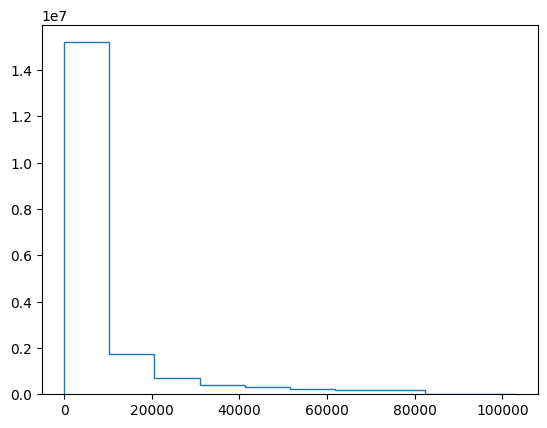

In [32]:
np.save("vicinity_of_10.npy", counts_small)
print_array_data(counts_small)

In [9]:
counts_large = tree.query_ball_point(points, r=1, workers=-1, return_length=True)

print(counts_large)

[188028 187051 187752 ...   1247   1322   1256]


(18880083,)
1.00 - 1736018.00
491899.87454721465


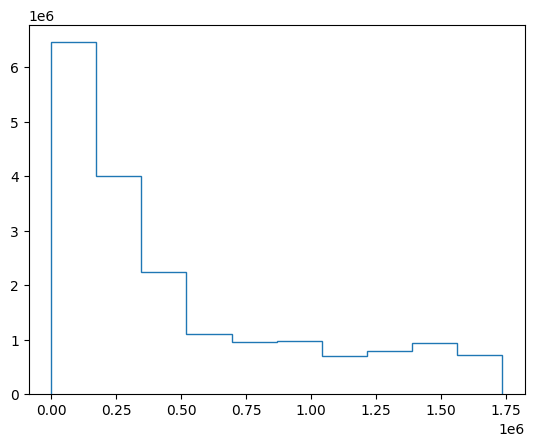

In [33]:
np.save("vicinity_of_100.npy", counts_large)
print_array_data(counts_large)

In [ ]:
test = np.load("vicinity_of_100.npy")

print(min(test - counts_large))

0


In [11]:
rel_density = counts_large / counts_small

(18880083,)
1.00 - 1620845.00
248.60672064294985


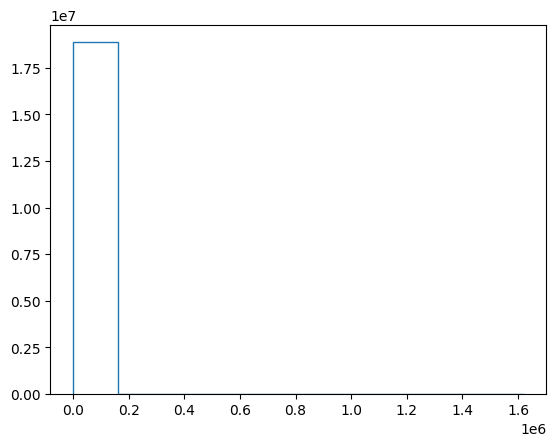

In [ ]:
print_array_data(rel_density)

(18392821,)
1.00 - 999.99
150.4052858630422


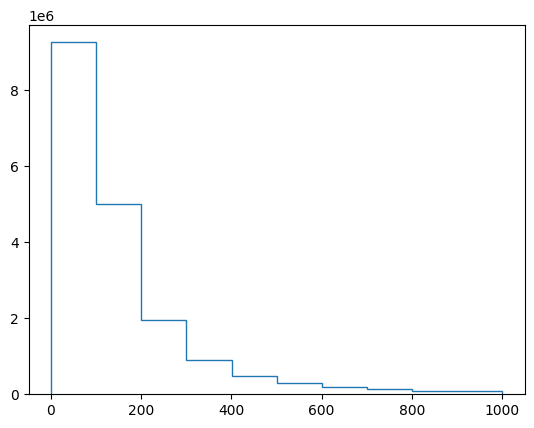

In [18]:
split = rel_density < 1000

lower = rel_density[split]

print_array_data(lower)

In [27]:
density_threshold = 500

mask = rel_density > density_threshold

las[mask].write("trees.las")

print_las_info("trees.las")


Файл: trees.las
Формат версии: 1.2
Количество точек: 1,296,075
Диапазон координат (X, Y, Z):
  X: 3.85 - 10.85  (ширина 7.00 м)
  Y: -3.03 - 3.97  (размах 7.00 м)
  Z: -1.56 - 18.57  (высота 20.13 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 26458.07 точек/м²

Пример точек:
x: 6.03 y: -2.31 z: -0.58
x: 6.03 y: -2.31 z: -0.57
x: 6.02 y: -2.30 z: -0.57



Файл: trees.las
Формат версии: 1.2
Количество точек: 487,259
Диапазон координат (X, Y, Z):
  X: 3.85 - 10.85  (ширина 7.00 м)
  Y: -3.03 - 3.97  (размах 7.00 м)
  Z: -1.56 - 18.57  (высота 20.13 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 9946.90 точек/м²

Пример точек:
x: 6.14 y: -2.29 z: -0.55
x: 6.03 y: -2.43 z: -0.02
x: 6.04 y: -2.43 z: -0.02


In [ ]:
candidates = np.vstack(candidates)
print(candidates.shape)

(777823, 3)


In [ ]:
las = laspy.read(las_path)

save_las_points(las, candidates, "can.las")

Saved 777,823 points to can.las


In [ ]:
print_las_info("can.las")


Файл: can.las
Формат версии: 1.2
Количество точек: 777,823
Диапазон координат (X, Y, Z):
  X: -0.15 - 39.85  (ширина 40.00 м)
  Y: -61.56 - -27.03  (размах 34.53 м)
  Z: 0.50 - 12.00  (высота 11.50 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 563.17 точек/м²

Пример точек:
x: -0.07 y: -60.33 z: 8.00
x: -0.10 y: -60.33 z: 8.02
x: -0.07 y: -60.32 z: 8.02


### Фильтрация кандидатов

In [ ]:
tree = cKDTree(candidates, leafsize=16)
neighbors = tree.query_ball_point(candidates, r=1)
counts = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [ ]:
N = candidates.shape[0]
tree = cKDTree(candidates, leafsize=16)
counts = np.empty(N, dtype=np.int32)

# Обход по чанкам, чтобы не получить гигантские списки
for start in range(0, N, chunk_size):
    end = min(N, start + chunk_size)
    # query_ball_point возвращает список списков индексов
    neighbors = tree.query_ball_point(candidates[start:end, :], r=0.1)
    # длины списков = количество соседей
    counts[start:end] = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [ ]:
# Порог: если в окрестности мало соседей, то - шум
print(counts)
print(f"{min(counts)} - {max(counts)}")
print(np.mean(counts))
print(np.average(counts))
mask = counts > 50

candidates_v2 = candidates[mask]
print(candidates_v2.shape)

[ 7  9  9 ... 11  8  8]
1 - 555
92.27824710763245
92.27824710763245
(438773, 3)


In [ ]:
print(sum(counts))

las = laspy.read(las_path)

save_las_points(las, candidates_v2, "can_v2.las")

71776143
Saved 438,773 points to can_v2.las
